# Spectral Validation of microSWIFTs with 4.5 m AWAC

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

import mission_tools

%load_ext autoreload
%autoreload 2
%matplotlib widget

# Validation Subset of Data
Times when microSWIFTs are in locations where the bottom elevation is 
between 4-5 meters for 10 consecutive minutes. This subset was first
found in the 4p5meterAWACSubset.ipynb notebook.

The subset of data consists of the following:

mission 7 - microSWIFTs 41, 37, 57, and 46

mission 18 - microSWIFTs 13, 23, 12, 4, and 5

mission 19 - microSWIFT 23

mission 26 - microSWIFT 37

mission 28 - microSWIFT 56

mission 59 - microSWIFTs 23 and 20

mission 60 - microSWIFT 71

In [2]:
mission_nc_path = '../microSWIFT_data/final_dataset/mission_18.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')
mission_dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: DUNEX microSWIFT drifter - Mission 18
    institution: University of Washington - Applied Physics Lab
    source: Observations from microSWIFT drifters deployed in the DUring Nearshore Events eXperiment (DUNEX)
    Conventions: CF-1.6
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    creator_country: USA
    creator_email: erainvil@uw.edu
    creator_name: EJ Rainville, Jim Thomson, Melissa Moulton, and Morteza Derakhti at University of Washington - Applied Physics Lab
    creator_phone: (303) 653-1226
    creator_sector: academic
    creator_state: Washington
    featureType: trajectory
    cdm_data_type: Trajectory
    platform: microSWIFT wave buoy
    publisher_country: USA
    publisher_email: frfwebmaster@usace.army.mil
    publisher_name: USACE/CHL/COAB
    history: 2022-12-28 23:19:30.086140 Python
    references: https://github.com/SASlabgroup/microSWIFT and http

<AxesSubplot: xlabel='Cross Shore Location [meters]', ylabel='Along Shore Location [meters]'>

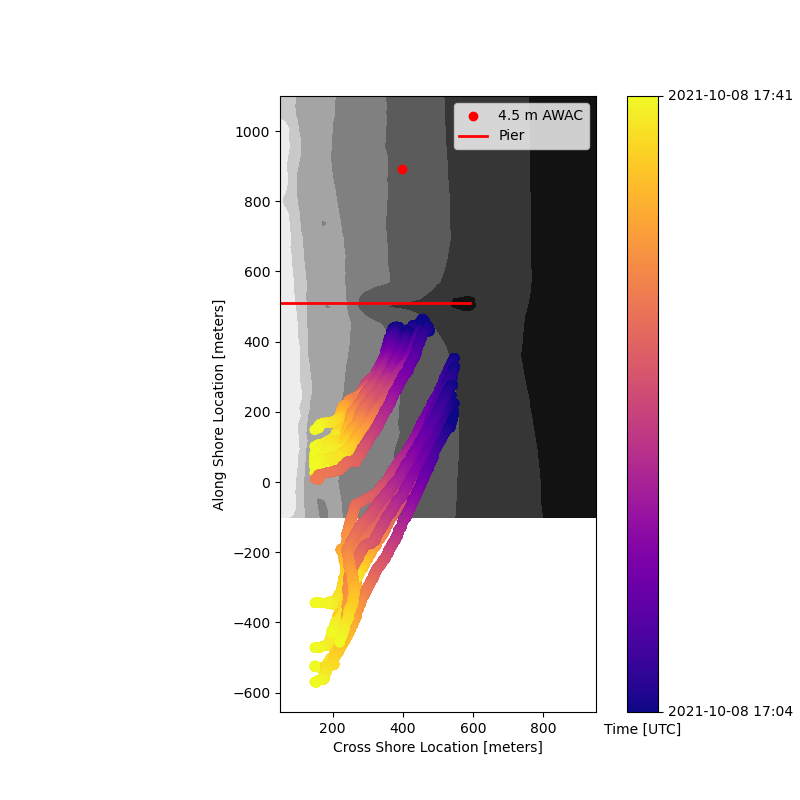

In [3]:
bathy_file = '../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
mission_tools.plot_mission_tracks(mission_dataset, bathy_file)

# Find the trajectories of the validation microSWIFTs

[40 13 14 22 24 23 12  4 39 38 17 19 21 20 18 11 29 56 57]


<AxesSubplot: xlabel='Cross Shore Location [meters]', ylabel='Along Shore Location [meters]'>

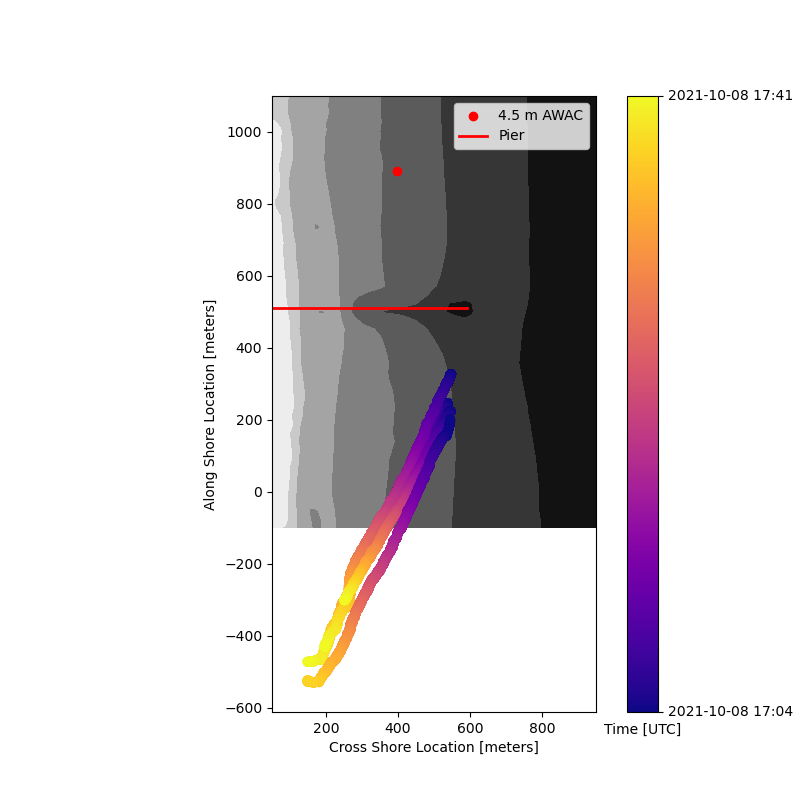

In [4]:
print(mission_dataset['trajectory'][:])
validation_trajectories = [1, 5, 6, 7] # indices of microSWIFTs 13, 23, 12, and 4
mission_tools.plot_mission_tracks(mission_dataset, bathy_file, validation_trajectories)

# Compute bathymetry along each track and find times when the microSWIFTs are between 4 and 5 meters 

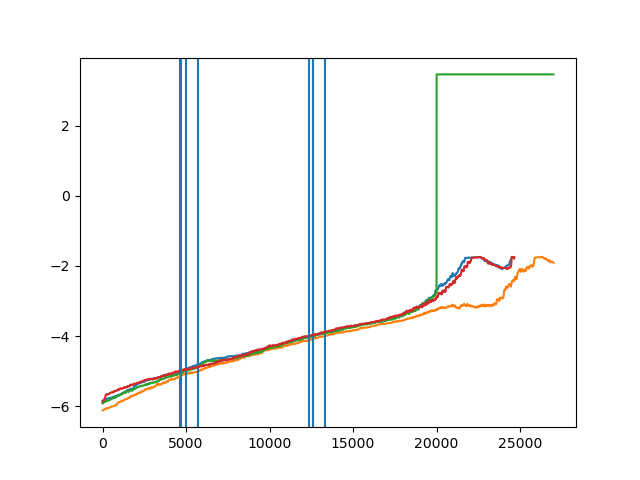

In [5]:
bathy_along_tracks = mission_tools.bathy_along_track(bathy_file,
                            mission_dataset['xFRF'][validation_trajectories,:],
                            mission_dataset['yFRF'][validation_trajectories,:])
depth_min = -5
depth_max = -4
in_depth_indices = mission_tools.ind_in_depth(bathy_along_tracks,
                                              depth_min,
                                              depth_max)

fig, ax = plt.subplots()
for n in np.arange(bathy_along_tracks.shape[0]):
    ax.plot(bathy_along_tracks[n,:])
    ax.axvline(in_depth_indices[n][0])
    ax.axvline(in_depth_indices[n][-1])
    

<AxesSubplot: xlabel='Cross Shore Location [meters]', ylabel='Along Shore Location [meters]'>

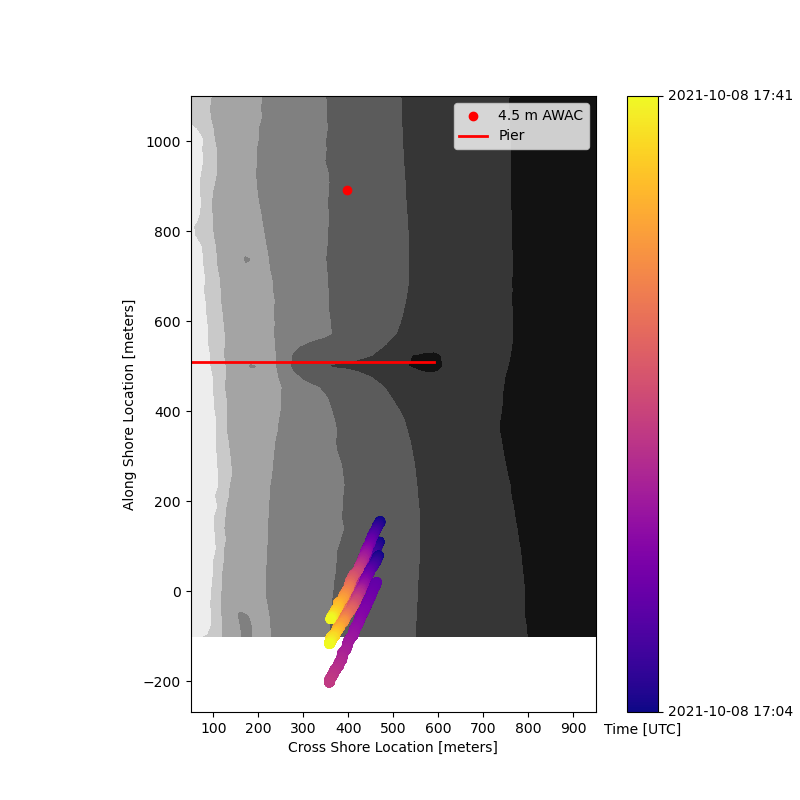

In [6]:
mission_tools.plot_mission_tracks(mission_dataset,
                                  bathy_file,
                                  validation_trajectories,
                                  in_depth_indices)

In [10]:
colors = ['k', 'g', 'b', 'y']

## Compute Spectra from each time series and Compare to the Closest AWAC Spectrum

/Users/edwinrainville/opt/miniconda3/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Text(0, 0.5, 'Energy Density [m^2 Hz^-1]')

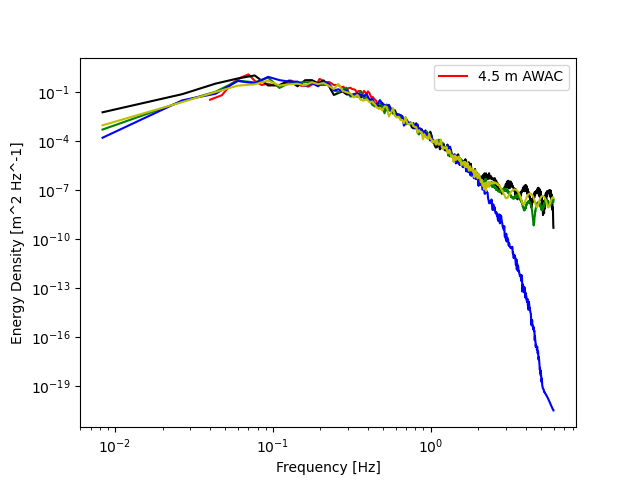

In [11]:
f_validation = []
E_validation = []
dof_validation = []
for n in range(len(validation_trajectories)):
    validation_time_series =  mission_dataset['sea_surface_elevation'][validation_trajectories[n], in_depth_indices[n]]
    f, E, dof = mission_tools.compute_spectra(validation_time_series, fs=12) 
    f_validation.append(f)
    E_validation.append(E)
    dof_validation.append(dof)

mission_time = np.median(mission_dataset['time'][:])
awac_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc'
awac_spectra, \
awac_freq = mission_tools.closest_awac_spectra(mission_time, awac_file)
fig, ax = plt.subplots()
ax.loglog(awac_freq, awac_spectra, color='r', label='4.5 m AWAC')
for n in range(len(validation_trajectories)):
    ax.loglog(f_validation[n],E_validation[n], color=colors[n])
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Energy Density [m^2 Hz^-1]')
